In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone, date
# from pysolar.solar import *
# from zoneinfo import ZoneInfo
from dateutil import tz
#import datetime
#import zoneinfo

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 200)

People_df=pd.read_csv("../data/raw/Traffic_Crashes_-_People.csv.gz", low_memory=False, compression='gzip')
Crashes_df=pd.read_csv("../data/raw/Traffic_Crashes_-_Crashes.csv.gz",low_memory=False, compression='gzip')
Vehicle_df=pd.read_csv("../data/raw/Traffic_Crashes_-_Vehicles.csv.gz",low_memory=False, compression='gzip')

#Crashes_df = pd.read_csv('Traffic_Crashes_-_Crashes.csv', low_memory=False)
#People_df = pd.read_csv('Traffic_Crashes_-_People.csv', low_memory=False)
#Vehicle_df = pd.read_csv('Traffic_Crashes_-_Vehicles.csv', low_memory=False)

In [3]:
Crashes=Crashes_df.copy()
People=People_df.copy()
Vehicle=Vehicle_df.copy()

# INITIAL FILTERING BEFORE the JOIN, FOR PERFORMANCE REASONS:

Crashes=Crashes[Crashes['REPORT_TYPE']=='ON SCENE']

Crashes=Crashes.query("CRASH_TYPE == 'INJURY AND / OR TOW DUE TO CRASH'")

#Vehicle = Vehicle[Vehicle_df['UNIT_NO']>1]
veh_type=['PASSENGER','SPORT UTILITY VEHICLE (SUV)','VAN/MINI-VAN','PICKUP','TRUCK - SINGLE UNIT','BUS OVER 15 PASS.']
Vehicle=Vehicle[Vehicle['VEHICLE_TYPE'].isin(veh_type)]

People=People[People['PERSON_TYPE']=="DRIVER"]

temp_df1=pd.merge(People, Vehicle, on=['CRASH_RECORD_ID','VEHICLE_ID'])
ALL_df=pd.merge(temp_df1, Crashes, on='CRASH_RECORD_ID')


In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# ALL_df.AGE.value_counts()

In [5]:
# ALL_df = ALL_df.query('AGE >= 0.0')

In [6]:
# GENERATING TARGET THROUGH binning and combining sec and prim causes:

targ_map ={ 'IMPROPER OVERTAKING/PASSING':'YES', 'UNABLE TO DETERMINE':'UNKNOWN',
       'IMPROPER BACKING':'YES', 'IMPROPER LANE USAGE':'YES',
       'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)':'YES',
       'DISREGARDING TRAFFIC SIGNALS':'YES',
       'FAILING TO REDUCE SPEED TO AVOID CRASH':'YES',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER':'YES',
       'FAILING TO YIELD RIGHT-OF-WAY':'YES', 'EQUIPMENT - VEHICLE CONDITION':'NO',
       'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)':'NO',
       'IMPROPER TURNING/NO SIGNAL':'YES', 'FOLLOWING TOO CLOSELY':'YES',
       'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE':'YES', 'DISREGARDING STOP SIGN':'YES',
       'NOT APPLICABLE':'UNKNOWN', 'DISTRACTION - FROM INSIDE VEHICLE':'NO',
       'DISTRACTION - FROM OUTSIDE VEHICLE':'NO',
       'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)':'YES',
       'ROAD ENGINEERING/SURFACE/MARKING DEFECTS':'NO',
       'DISREGARDING OTHER TRAFFIC SIGNS':'YES', 'TEXTING':'YES',
       'DRIVING ON WRONG SIDE/WRONG WAY':'YES', 'PHYSICAL CONDITION OF DRIVER':'YES',
       'ANIMAL':'NO', 'WEATHER':'NO', 'ROAD CONSTRUCTION/MAINTENANCE':'NO',
       'DISREGARDING YIELD SIGN':'YES', 'CELL PHONE USE OTHER THAN TEXTING':'YES',
       'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST':'NO',
       'TURNING RIGHT ON RED':'YES', 'RELATED TO BUS STOP':'NO',
       'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)':'YES',
       'DISREGARDING ROAD MARKINGS':'YES', 'OBSTRUCTED CROSSWALKS':'NO',
       'PASSING STOPPED SCHOOL BUS':'YES',
       'EXCEEDING SAFE SPEED FOR CONDITIONS':'YES',
       'EXCEEDING AUTHORIZED SPEED LIMIT':'YES',
       'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT':'NO',
       'BICYCLE ADVANCING LEGALLY ON RED LIGHT':'NO'}

def create_target(this_driver_action, driver_error, driver_sec_error, phys_condition):
    if this_driver_action not in ['NONE','OTHER','UNKNOWN']:
        guilty='YES'
    elif this_driver_action == 'NONE':
        guilty='NO'
    elif this_driver_action in ['OTHER','UNKNOWN'] and phys_condition in ['MEDICATED','FATIGUED/ASLEEP','ILLNESS/FAINTED'] :
        guilty='NO'        
    else: 
        guilty = driver_error

    if guilty == 'UNKNOWN' and driver_error == 'UNKNOWN' and driver_sec_error == 'NO':
        guilty='NO'
    return guilty

ALL_df['SOME_DRIVER_ERROR']=ALL_df['PRIM_CONTRIBUTORY_CAUSE'].replace(targ_map)
ALL_df['SOME_DRIVER_SEC_ERROR']=ALL_df['SEC_CONTRIBUTORY_CAUSE'].replace(targ_map)

ALL_df['GUILTY']=ALL_df.apply(lambda row: create_target(row['DRIVER_ACTION'], row['SOME_DRIVER_ERROR'], 
                                                        row['SOME_DRIVER_SEC_ERROR'],row['PHYSICAL_CONDITION']), axis=1)

ALL_df = ALL_df[ALL_df['GUILTY']!='UNKNOWN']

In [7]:
ALL_df['GUILTY'].value_counts()
#Crashes.CRASH_TYPE.unique()

YES    88968
NO     76258
Name: GUILTY, dtype: int64

In [8]:
# ALL_df.info

In [9]:
#temp_df=ALL_df[ALL_df['GUILTY']=='MAYBE'].copy()
#temp_df.head(80)[['CRASH_RECORD_ID','UNIT_NO','MODEL','GUILTY', 'DRIVER_ACTION','PRIM_CONTRIBUTORY_CAUSE','SEC_CONTRIBUTORY_CAUSE']].sort_values(by=['CRASH_RECORD_ID','UNIT_NO'])


In [10]:
# Dividing on training and testing sets

y=ALL_df['GUILTY']
ALL_COL=ALL_df.drop(['GUILTY'],axis=1)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(ALL_COL, y, random_state=100, stratify=y)

train_df=pd.concat([X_train,Y_train], axis=1)
test_df=pd.concat([X_test,Y_test], axis=1)



In [11]:
df=train_df.copy()
df.dropna(subset=['LONGITUDE','LATITUDE'], axis=0, inplace=True)

# to_zone = tz.gettz('America/Chicago')
# df["CRASH_DATE"]= df["CRASH_DATE"].map(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y %I:%M:%S %p").replace(tzinfo=to_zone))


# import pysolar.solar as pys

# def get_sun_position (lat,long,date, direction, light, sun):
#     az=get_azimuth_fast(lat, long, date)
#     alt=get_altitude_fast(lat, long, date)
#     glare=0
#     if  alt < 40 and alt > 0 and light == 'DAYLIGHT' and sun == 'CLEAR':
#         if az <= 180 and direction in ('E','SE','S'):
#             glare=1
#         elif az >= 180 and direction in ('W','SW','S'):
#             glare=1
#         else: glare=0
#     return pd.Series([glare, az,alt])


# lambdafunc= lambda row: get_sun_position(row['LATITUDE'], 
#                              row['LONGITUDE'], 
#                              row['CRASH_DATE'].to_pydatetime(), 
#                              row['TRAVEL_DIRECTION'],
#                              row['LIGHTING_CONDITION'], 
#                              row['WEATHER_CONDITION'])
# #temp_df=df.head(20000).copy()

# df[['SUN_GLARE','SUN_AZIMUTH','SUN_ALTITUDE']]=df.apply(lambdafunc, axis=1)


In [12]:
## REPLACE WITH SKLEARN IMPUTERS

df['EXCEED_SPEED_LIMIT_I']=df['EXCEED_SPEED_LIMIT_I'].fillna('UNKNOWN')
df['INTERSECTION_RELATED_I']=df['INTERSECTION_RELATED_I'].fillna('UNKNOWN')
df['FIRST_CONTACT_POINT']=df['FIRST_CONTACT_POINT'].fillna('UNKNOWN')
df['NUM_PASSENGERS']=df['NUM_PASSENGERS'].fillna(0)
df['DRIVERS_LICENSE_CLASS']=df['DRIVERS_LICENSE_CLASS'].fillna('D')

df.dropna(subset=['MAKE','MODEL','VEHICLE_YEAR'], axis=0, inplace=True)

df['VEHICLE_DEFECT']=df['VEHICLE_DEFECT'].replace( {'UNKNOWN':'NONE'}).copy()

df=df[df['WEATHER_CONDITION']!='UNKNOWN']
df=df[df['LIGHTING_CONDITION']!='UNKNOWN']

df=df[df['DRIVERS_LICENSE_CLASS'].isin(["A","B","C","D","DM","AM","BM","CD"])]

df['DRIVERS_LICENSE_CLASS']=np.where(df['DRIVERS_LICENSE_CLASS'].isin(["A","B","C","AM","BM","CD","S"]),'CDL',
                                     df['DRIVERS_LICENSE_CLASS'])
df['DRIVERS_LICENSE_CLASS']=np.where(df['DRIVERS_LICENSE_CLASS']=='DM','D', df['DRIVERS_LICENSE_CLASS'])

df.loc[df.query("CELL_PHONE_USE =='Y' and DRIVER_ACTION in (['UNKNOWN','NONE'])").index ,['DRIVER_ACTION']] = 'CELL PHONE USE'

df=df.query('SEX!="X"')

proper_speed=np.arange(0,80,5)
df=df[df['POSTED_SPEED_LIMIT'].isin(proper_speed)].copy()

# df = df.query('AGE>14 and AGE <101')
# df['AGE_GROUP'] = pd.cut(x=df['AGE'], bins=[15, 24, 35, 55, 70, 80, 100], 
#                          labels=['YOUNG', 'YOUNG ADULTS','ADULTS','MIDDLE AGED','SENIORS', '80+'])

# df=df[df['VEHICLE_YEAR']<=date.today().year]
# df=df[df['VEHICLE_YEAR']>1900]

# latest=date.today().year
# oldest=df['VEHICLE_YEAR'].min()

# vehicle_age=[oldest-1, latest-25, latest-15, latest-8, latest-3, latest ]
# vehicle_age_labels=['25+ years old', '15-25 years old','8-15 years old','3-8 years old','0-3 years old']
# df['VEHICLE_AGE'] = pd.cut(x=df['VEHICLE_YEAR'], bins=vehicle_age, labels=vehicle_age_labels, right=False)


# Clean Above -----------Modeling Below ----------------

In [13]:
cols=['GUILTY','DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','ROAD_DEFECT','POSTED_SPEED_LIMIT','VEHICLE_DEFECT',
            'ALIGNMENT', 'LIGHTING_CONDITION', 'WEATHER_CONDITION','SEX','DRIVERS_LICENSE_CLASS',  
            'PHYSICAL_CONDITION', 'MANEUVER','NUM_PASSENGERS', 'VEHICLE_YEAR', 'DRIVER_VISION', 'AGE']

# Removed ,'SUN_GLARE' from cols 

X=df[cols].copy()
# X=X.dropna()
y_train = X['GUILTY']
X_train = X.drop(columns = 'GUILTY')

In [14]:
X_train.columns

Index(['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT',
       'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'POSTED_SPEED_LIMIT', 'VEHICLE_DEFECT', 'ALIGNMENT',
       'LIGHTING_CONDITION', 'WEATHER_CONDITION', 'SEX',
       'DRIVERS_LICENSE_CLASS', 'PHYSICAL_CONDITION', 'MANEUVER',
       'NUM_PASSENGERS', 'VEHICLE_YEAR', 'DRIVER_VISION', 'AGE'],
      dtype='object')

In [15]:
def explore_cat_vars(df, n):
    col_counts=pd.DataFrame(df.nunique(),).reset_index()
    col_counts.columns=(["Col_Name", "Count"])
    for col in col_counts[col_counts['Count'] < n]['Col_Name']:
        print('--------------------------------------')
        print(col)
        print('--------------------------------------')
        print(df[col].value_counts())
    print("=================================================================================================")
    print(col_counts[col_counts['Count'] >= n])

#explore_cat_vars(X, 42)

X_train.nunique()

DEVICE_CONDITION           8
FIRST_CRASH_TYPE          18
FIRST_CONTACT_POINT       14
TRAFFICWAY_TYPE           20
ROADWAY_SURFACE_COND       7
ROAD_DEFECT                7
POSTED_SPEED_LIMIT        13
VEHICLE_DEFECT            15
ALIGNMENT                  6
LIGHTING_CONDITION         5
WEATHER_CONDITION         10
SEX                        2
DRIVERS_LICENSE_CLASS      2
PHYSICAL_CONDITION        12
MANEUVER                  25
NUM_PASSENGERS            25
VEHICLE_YEAR             101
DRIVER_VISION             14
AGE                      104
dtype: int64

In [16]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn import set_config
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
set_config(display ="diagram")

# cat_encoded = ColumnTransformer(transformers=[
#     ("ohe", OneHotEncoder(drop='first', handle_unknown="ignore"), ["category"])
# ], remainder="passthrough")

In [17]:
X_train.columns

Index(['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT',
       'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'POSTED_SPEED_LIMIT', 'VEHICLE_DEFECT', 'ALIGNMENT',
       'LIGHTING_CONDITION', 'WEATHER_CONDITION', 'SEX',
       'DRIVERS_LICENSE_CLASS', 'PHYSICAL_CONDITION', 'MANEUVER',
       'NUM_PASSENGERS', 'VEHICLE_YEAR', 'DRIVER_VISION', 'AGE'],
      dtype='object')

In [18]:
# X.NUM_PASSENGERS.value_counts()

In [19]:
# explore_cat_vars(X_train, 25)

In [21]:
ordinal_columns = ['DRIVERS_LICENSE_CLASS']
numeric_columns = ['AGE', 'VEHICLE_YEAR']
nominal_columns = ['FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'TRAFFICWAY_TYPE', 
                   'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'POSTED_SPEED_LIMIT', 'VEHICLE_DEFECT',
                  'ALIGNMENT', 'WEATHER_CONDITION', 'SEX', 'PHYSICAL_CONDITION',
                   'MANEUVER', 'DRIVER_VISION', 'NUM_PASSENGERS',
                   'DEVICE_CONDITION', 'LIGHTING_CONDITION']

#drivers_order = 

In [25]:
### Pipeline framework for numeric columns

numeric_pipeline = Pipeline([('AGEimputer', IterativeImputer()), ('numnorm', StandardScaler())])




### Pipeline framework for ordinal columns

# ordinal_pipeline = Pipeline([
#     ('ordimputer', SimpleImputer(strategy = 'most_frequent')),
#     ('ordenc', OrdinalEncoder(categories = [ed_list])),
#     ('ordnorm', StandardScaler())])



### Pipeline framework for nominal columns

nominal_pipeline = Pipeline([
#     ('onehotimputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore'))])

ct = ColumnTransformer(
#     [("ordinalpipe", ordinal_pipeline, ordinal_columns), 
     [("nominalpipe", nominal_pipeline, nominal_columns),
     ('ord_as_nom_temporarily', nominal_pipeline, ordinal_columns),
     ("numeric_pipe", numeric_pipeline, numeric_columns)])


In [24]:
X_train.isna().sum()

DEVICE_CONDITION            0
FIRST_CRASH_TYPE            0
FIRST_CONTACT_POINT         0
TRAFFICWAY_TYPE             0
ROADWAY_SURFACE_COND        0
ROAD_DEFECT                 0
POSTED_SPEED_LIMIT          0
VEHICLE_DEFECT              0
ALIGNMENT                   0
LIGHTING_CONDITION          0
WEATHER_CONDITION           0
SEX                         0
DRIVERS_LICENSE_CLASS       0
PHYSICAL_CONDITION          0
MANEUVER                    0
NUM_PASSENGERS              0
VEHICLE_YEAR                0
DRIVER_VISION               0
AGE                      5574
dtype: int64

In [117]:
# pd.DataFrame(ct.fit_transform(X)).head()

# Baseline Logistic Regression

In [118]:
baseline_pipe = Pipeline([('preprocess', ct),
                          ('standardscale', StandardScaler()),
                          ('model',LogisticRegression(max_iter = 10000))])
# baseline_pipe

In [119]:
baseline_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['FIRST_CRASH_TYPE',
                                                   'FIRST_CONTACT_POINT',
                                                   'TRAFFICWAY_TYPE',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                                                   'POSTED_SPEED_LIMIT',
                                                   'VEHICLE_DEFECT',
                                                   'ALIGNMENT',
                                                   'WEATHER_CONDITION', 'SEX',
                                                   'PH...
                                                 ('ord_as_nom_temporarily',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['DRIVERS_LICENSE_CLASS']),
                                                 ('numeric_pipe',
                                                  Pipeline(steps=[('AGEimputer',
                                                                   IterativeImputer()),
                                                                  ('numnorm',
                                                                   StandardScaler())]),
                                                  ['AGE', 'VEHICLE_YEAR'])])),
                ('standardscale', StandardScaler()),
                ('model', LogisticRegression(max_iter=10000))])

In [87]:
# baseline_pipe

In [88]:
y_pred = baseline_pipe.predict(X_train)

In [89]:
print('Precision : ', precision_score(y_train, y_pred, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, y_pred, pos_label="NO"),
      '\n Score :', accuracy_score(y_train, y_pred,))

Precision :  0.7276328755002313 
 Recall score:  0.7414701120924609 
 Score : 0.7377364732773918


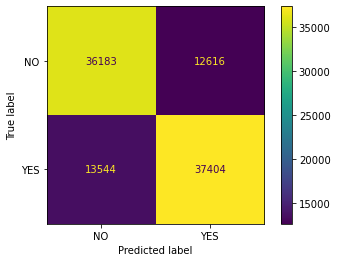

In [90]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)

# Baseline Decision trees 

In [27]:
#baseline_tree_pipe = Pipeline([('preprocess', ct),
#                                  ('onehotss', StandardScaler(with_mean = False)),
#                                  ('model',DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=20,
#                                                                  min_samples_split=10, min_samples_leaf=5))])


bagged_tree_pipe = Pipeline([('preprocess', ct),
                                  ('onehotss', StandardScaler(with_mean = False)),
                                  ('model', BaggingClassifier(DecisionTreeClassifier(criterion='gini', 
                                                                  splitter='best',max_depth=20,
                                                                  min_samples_split=10, min_samples_leaf=5),
                                                             n_estimators=20) )])


bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

NameError: name 'BaggingClassifier' is not defined

In [92]:
baseline_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['FIRST_CRASH_TYPE',
                                                   'FIRST_CONTACT_POINT',
                                                   'TRAFFICWAY_TYPE',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                                                   'POSTED_SPEED_LIMIT',
                                                   'VEHICLE_DEFECT',
                                                   'ALIGNMENT',
                                                   'WEATHER_CONDITION', 'SEX',
                                                   'PH...
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['DRIVERS_LICENSE_CLASS']),
                                                 ('numeric_pipe',
                                                  Pipeline(steps=[('AGEimputer',
                                                                   IterativeImputer()),
                                                                  ('numnorm',
                                                                   StandardScaler())]),
                                                  ['AGE', 'VEHICLE_YEAR'])])),
                ('onehotss', StandardScaler(with_mean=False)),
                ('model',
                 DecisionTreeClassifier(max_depth=20, min_samples_leaf=5,
                                        min_samples_split=10))])

In [93]:
tree_pred = baseline_tree_pipe.predict(X_train)

In [94]:
print('Precision : ', precision_score(y_train, tree_pred, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, tree_pred, pos_label="NO"),
      '\n Score :', accuracy_score(y_train, tree_pred,))

Precision :  0.7817371475953565 
 Recall score:  0.7727822291440398 
 Score : 0.7832817027078509


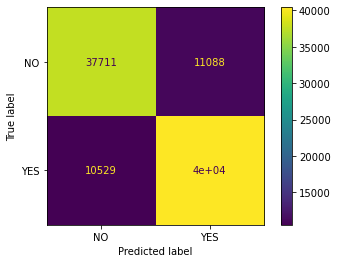

In [95]:
ConfusionMatrixDisplay.from_predictions(y_train, tree_pred)

# Baseline Test ==========================================

In [27]:
y_test = test_df['GUILTY']
X_test = test_df.drop(columns = 'GUILTY')

In [ ]:
onehc = OneHotEncoder(sparse = False, drop = 'first', handle_unknown = 'ignore')
X_test_transformed  = onehc.fit_transform(X_test)
y_pred_test = baseline_pipe.predict(X_test_transformed)

# ignore unknown 

In [ ]:
print('Precision : ', precision_score(y_train, y_pred, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, y_pred, pos_label="NO"),
      '\n Score :', accuracy_score(y_train, y_pred,))

In [ ]:
plot_confusion_matrix(baseline_pipe, X_train,
                      y_train)